# Sounding parameters automatic analysis with regards to Skew T

Import all needed libraries for analysis. Matplotlib, pandas and numpy are used for standard data analysis. Urllib, bs4 and re are used for web scrapping data collection and processing. Siphon is used from Unidata's Library for faster and simpler sounding data collection in pandas format.

In [1]:
from siphon.simplewebservice.wyoming import WyomingUpperAir
from datetime import datetime
import matplotlib.pyplot as plt
from pylab import rcParams
import urllib.request
from bs4 import BeautifulSoup
import re
import pandas as pd
import numpy as np
import math

Enter desired date and station number (ID). Data is acquired from Wyoming University Website ( http://weather.uwyo.edu/upperair/sounding.html ). For more details on available stations, further research on website is recommended. Data for Zagreb is used here (ID = LDDD or 14240) and turbulent stormy day was chosen (7.7.2019.). Day, month and year data is available for atleast last ten years. Since the soundings are launched only at 0 and 12 UTC, those are only possible values for hours. Note: Mistakes are possible, especially regarding comlete sounding data which could be missing for some days/hours.

In [2]:
date = datetime(2019,7,7,12)
station = 'LDDD'

Getting data into pandas Dataframe using Siphon Library. Adjusting size for plots. Data used for this analysis (df1) can be seen in table on this link (first table): http://weather.uwyo.edu/cgi-bin/sounding?region=europe&TYPE=TEXT%3ALIST&YEAR=2019&MONTH=07&FROM=0712&TO=0712&STNM=LDDD. 

In [3]:
df1 = WyomingUpperAir.request_data(date,station)

rcParams['figure.figsize'] = 16, 10

Scrapping data from the same website. Since Siphon only fetches data from sounding levels (df1), various indices and parameters (same link from above, data under 'Station information and sounding indices') must be scrapped, cleaned and stored manually to dataframe called df2. 

In [4]:
Year = date.year
Month = date.month
Day = date.day
Hour = date.hour

if (date.hour == 0):
    url = 'http://weather.uwyo.edu/cgi-bin/sounding?region=europe&TYPE=TEXT%3ALIST&YEAR={Year}&MONTH=0{Month}&FROM=0{Day}0{Hour}&TO=0{Day}0{Hour}&STNM={Station}'.format(Year = Year, Month = Month, Day = Day, Hour = Hour, Station = station)
else:
    url = 'http://weather.uwyo.edu/cgi-bin/sounding?region=europe&TYPE=TEXT%3ALIST&YEAR={Year}&MONTH=0{Month}&FROM=0{Day}{Hour}&TO=0{Day}{Hour}&STNM={Station}'.format(Year = Year, Month = Month, Day = Day, Hour = Hour, Station = station)

response = urllib.request.urlopen(url)
html = response.read()

soup = BeautifulSoup(html,features="lxml")
data = soup.find_all('pre')

Sound_data = str(data[1])

x = re.findall(r'[-+]?[.]?[\d].+', Sound_data)

x1 = []

i = 0
for i in range(0, len(x)):
    if (i != 1 and 'thickness' not in x[i]):
        x[i] = float(x[i])
        x1.append(x[i])
    i = i + 1
    
y = ['Station number', 'Station latitude', 'Station longitude', 'Station elevation', \
     'Showalter index', 'Lifted index', 'LIFT computed using virtual temperature', 'SWEAT index', 'K index', \
     'Cross totals index', 'Vertical totals index', 'Totals totals index', 'Convective Available Potential Energy', \
     'CAPE using virtual temperature', 'Convective Inhibition', 'CINS using virtual temperature', 'Equilibrum Level', \
     'Equilibrum Level using virtual temperature', 'Level of Free Convection', 'LFCT using virtual temperature', \
     'Bulk Richardson Number', 'Bulk Richardson Number using CAPV', 'Temp [K] of the Lifted Condensation Level', \
     'Pres [hPa] of the Lifted Condensation Level', 'Mean mixed layer potential temperature', \
     'Mean mixed layer mixing ratio', 'Precipitable water [mm] for entire sounding']

y1 = []

j = 0
for j in range(0, len(y)):
    if (y[j] in Sound_data):
        y1.append(y[j])
    j = j + 1
    
all_data = {'Parameter': y1, 'Value': x1}
df2 = pd.DataFrame(data = all_data)


Now, when our data is ready, comes the fun part. 

Expected weather type is divided in four categories regarding their strength and attributes when present. 

Categories:

1. No storms - Low chance for any kind of storm, even showers. Regardless of that, weather can still be cloudy or even rainy (snowy).

2. Thunderstorms - Weak convective processes with showers and probably some thunder. Small hail and stronger wind gusts possible if certain conditions are met (rarely).

3. Severe storms - Medium to strong convective processes with (heavy) rain, thunderstorms, strong wind gusts, (bigger) hail. 

4. Supercells - (Very) strong convective processes with possible extremly heavy rain, big hail, very high winds and even tornado. 

Each type gets or loses points if certain conditions are met. At the end of calculation, points gained for each type are divided by maximum possible points for each type of weather. In that way we get percentage of realization which can then be divided into three groups (low chance, medium chance, high chance). 

For starters, all are initialised to zero.


In [5]:
no_storms = 0
moderate_storms = 0
strong_storms = 0
supercells = 0

#### Lifted Index (LI)

Lifted Index is an indice used to assess low level parcel (in)stability of the troposphere. 

It represents difference in temperature between parcel of air raised from 50 mb above the surface to the 500 mb level compared to the 500 mb actual (environmental) temperature.

Instability: A negative LI indicates that the PBL is unstable with respect to the middle troposphere. This is an environment in which convection can occur. The more negative the LI the more unstable the troposphere and the more buoyant the acceleration will be for rising parcels of air from the PBL.

In [6]:
LI = int(df2[df2['Parameter']=='LIFT computed using virtual temperature'].index.values.astype(int)[0])

if (df2.iloc[LI]['Value'] < -6):
    strong_storms = strong_storms + 2
    moderate_storms = moderate_storms + 2
        
elif (df2.iloc[LI]['Value'] < -3 and df2.iloc[LI]['Value'] >= -6):
    strong_storms = strong_storms + 1
    moderate_storms = moderate_storms + 1
    
elif (df2.iloc[LI]['Value'] < 0 and df2.iloc[LI]['Value'] >= -3):
    moderate_storms = moderate_storms + 1

else:
    strong_storms = strong_storms - 1
    moderate_storms = moderate_storms - 1
    no_storms = no_storms + 1

#### Severe Weather Threat Index (sweat)

Sweat uses several variables to determine the likeliness of severe weather and tornadoes. The SWEAT index assess low level moisture, convective environment (via TT), and changes in wind speed and direction with height (low level and middle level jet, horizontal vorticity). When all these factors occur together, the severe weather threat and tornado threat is enhanced. 

In [7]:
sweat = int(df2[df2['Parameter']=='SWEAT index'].index.values.astype(int)[0])

if (df2.iloc[sweat]['Value'] >= 400):
    supercells = supercells + 2
    strong_storms = strong_storms + 3
elif (df2.iloc[sweat]['Value'] >= 300 and df2.iloc[sweat]['Value'] < 400):
    supercells = supercells + 1
    strong_storms = strong_storms + 2
elif (df2.iloc[sweat]['Value'] >= 150 and df2.iloc[sweat]['Value'] < 300):
    strong_storms = strong_storms + 1
else:
    supercells = supercells - 1
    strong_storms = strong_storms - 1

#### K Index (KI)

The K INDEX is an index used to assess convective potential. 

In [8]:
KI = int(df2[df2['Parameter']=='K index'].index.values.astype(int)[0])
    
if (df2.iloc[KI]['Value'] >= 40):
    strong_storms = strong_storms + 2
    moderate_storms = moderate_storms + 2
elif (df2.iloc[KI]['Value'] >= 20 and df2.iloc[KI]['Value'] < 40):
    strong_storms = strong_storms + 1
    moderate_storms = moderate_storms + 1
else:
    strong_storms = strong_storms - 1
    moderate_storms = moderate_storms - 1
    no_storms = no_storms + 1

#### Total totals (TT) Index

The Total Totals is an index used to assess storm strength. 

In [9]:
TT = int(df2[df2['Parameter']=='Totals totals index'].index.values.astype(int)[0])
    
if (df2.iloc[TT]['Value'] >= 53):
    supercells = supercells + 2
    strong_storms = strong_storms + 2
elif (df2.iloc[TT]['Value'] >= 51 and df2.iloc[TT]['Value'] < 53):
    supercells = supercells + 1
    strong_storms = strong_storms + 1
    moderate_storms = moderate_storms + 1
elif (df2.iloc[TT]['Value'] >= 44 and df2.iloc[TT]['Value'] < 50):
    supercells = supercells - 1
    strong_storms = strong_storms - 1
    moderate_storms = moderate_storms + 1
else:
    supercells = supercells - 2
    strong_storms = strong_storms - 2
    moderate_storms = moderate_storms - 1
    no_storms = no_storms + 1  

#### Convective Available Potential Energy (CAPE) and Wind Shear 0-6 km (shear)

Convective Available Potential Energy is the integration of the positive area on a Skew-T sounding. The positive area is that region where the theoretical parcel temperature is warmer than the actual temperature at each pressure level in the troposphere. The theoretical parcel temperature is the lapse rate(s) a parcel would take if raised from the lower PBL. 

High CAPE means storms will build vertically very quickly. The updraft speed depends on the CAPE environment.

Hail: As CAPE increases (especially above 2,500 J/kg) the hail potential increases. Large hail requires very large CAPE values.

Downdraft: An intense updraft often produces an intense downdraft since an intense updraft will condense out a large amount of moisture. Expect isolated regions of very heavy rain when storms form in a large or extreme CAPE environment.

Lightning: Large and extreme CAPE will produce storms with abundant lightning. 

Wind shear is usually calculated as difference in wind speed between 0 and 6 km altitude since those are most important levels for storm development. Higher shear gives long living and better organised storms, especially if its combined with big directional shear - great for supercells and tornadoes.

In [10]:
CAPE = int(df2[df2['Parameter']=='CAPE using virtual temperature'].index.values.astype(int)[0])

six = int(df1[df1['height'] >= 6000].index[0])
dir_0km = df1['direction'].iloc[0]
dir_6km = df1['direction'].iloc[six]
speed_0km_x = df1['speed'].iloc[0] * math.cos(math.radians(-dir_0km+90))
speed_0km_y = df1['speed'].iloc[0] * math.sin(math.radians(-dir_0km+90))
speed_6km_x = df1['speed'].iloc[six] * math.cos(math.radians(-dir_6km+90))
speed_6km_y = df1['speed'].iloc[six] * math.sin(math.radians(-dir_6km+90))
shear = 0.514 * (math.sqrt((speed_6km_x - speed_0km_x)**2 + (speed_6km_y - speed_0km_y)**2))

if (df2.iloc[CAPE]['Value'] >= 2000):
    if (shear >= 20):
        supercells = supercells + 7
        strong_storms = strong_storms + 7
    elif (shear >= 15 and shear < 20):
        supercells = supercells + 6
        strong_storms = strong_storms + 6
    elif (shear >= 10 and shear < 15):
        supercells = supercells + 3
        strong_storms = strong_storms + 5
    else:
        strong_storms = strong_storms + 3
        supercells = supercells - 3
    moderate_storms = moderate_storms + 1
    
elif (df2.iloc[CAPE]['Value'] >= 1500 and df2.iloc[CAPE]['Value'] < 2000):
    if (shear >= 20):
        supercells = supercells + 6
        strong_storms = strong_storms + 6
    elif (shear >= 14.9 and shear < 20):
        supercells = supercells + 5
        strong_storms = strong_storms + 5
    elif (shear >= 10 and shear < 14.9):
        supercells = supercells + 3
        strong_storms = strong_storms + 4
    else:
        strong_storms = strong_storms + 2
        supercells = supercells - 3
    moderate_storms = moderate_storms + 1
    
elif (df2.iloc[CAPE]['Value'] >= 1000 and df2.iloc[CAPE]['Value'] < 1500):
    if (shear >= 20):
        supercells = supercells + 5
        strong_storms = strong_storms + 5
    elif (shear >= 15 and shear <= 20):
        supercells = supercells + 4
        strong_storms = strong_storms + 4
    elif (shear >= 10 and shear <= 15):
        supercells = supercells + 2
        strong_storms = strong_storms + 3
    else:
        strong_storms = strong_storms + 1
        supercells = supercells - 3
    moderate_storms = moderate_storms + 1
    
elif (df2.iloc[CAPE]['Value'] >= 500 and df2.iloc[CAPE]['Value'] < 1000):
    if (shear >= 20):
        supercells = supercells + 4
        strong_storms = strong_storms + 4
    elif (shear >= 15 and shear <= 20):
        supercells = supercells + 3
        strong_storms = strong_storms + 3
    elif (shear >= 10 and shear <= 15):
        strong_storms = strong_storms + 2
        supercells = supercells - 1
    else:
        strong_storms = strong_storms - 1
        supercells = supercells - 3
    moderate_storms = moderate_storms + 1
    
elif (df2.iloc[CAPE]['Value'] >= 70 and df2.iloc[CAPE]['Value'] < 500):
    if (shear >= 20):
        supercells = supercells + 3
        strong_storms = strong_storms + 3
        moderate_storms = moderate_storms + 2
    elif (shear >= 15 and shear <= 20):
        strong_storms = strong_storms + 2
        supercells = supercells - 1
        moderate_storms = moderate_storms + 2
    elif (shear >= 10 and shear <= 15):
        moderate_storms = moderate_storms + 1
        supercells = supercells - 3
    else:
        strong_storms = strong_storms - 1
        supercells = supercells - 4
        no_storms = no_storms + 1
        
elif (df2.iloc[CAPE]['Value'] < 70):
    if (shear >= 20):
        strong_storms = strong_storms + 2
        moderate_storms = moderate_storms + 2
    elif (shear >= 15 and shear <= 20):
        supercells = supercells - 1
        moderate_storms = moderate_storms + 1
    else:
        supercells = supercells - 3
        strong_storms = strong_storms - 2
        no_storms = no_storms + 1

#### Convective Inhibition (CIN)

Convective Inhibition is anti-CAPE (negative CAPE) in the lower troposphere. This is the region where a parcel of air if raised from the lower PBL would sink back down again. Another term for CIN is a capping layer. The capping layer must be broken before lower PBL based lifting is able to move into the +CAPE region of a sounding and develop into deep convection. 

CIN will be reduced by: 1) daytime heating, 2) synoptic upward forcing, 3) low level convergence, 4) low level warm air advection (especially if accompanied by higher dewpoints). CIN is most likely to be small in the late afternoon since daytime heating plays a crucial role in reducing it. 

In [11]:
CIN = int(df2[df2['Parameter']=='CINS using virtual temperature'].index.values.astype(int)[0])
    
if (df2.iloc[CIN]['Value'] <= -130 and df2.iloc[CAPE]['Value'] < 500):
    supercells = supercells - 3
    strong_storms = strong_storms - 3
    moderate_storms = moderate_storms - 3
    no_storms = no_storms + 3
elif (df2.iloc[CIN]['Value'] <= -130 and df2.iloc[CAPE]['Value'] > 500):
    supercells = supercells - 2
    strong_storms = strong_storms - 2
    moderate_storms = moderate_storms - 2
    no_storms = no_storms + 2
elif (df2.iloc[CIN]['Value'] <= -50 and df2.iloc[CIN]['Value'] > -130 and df2.iloc[CAPE]['Value'] < 200):
    supercells = supercells - 3
    strong_storms = strong_storms - 3
    moderate_storms = moderate_storms - 3
    no_storms = no_storms + 3
elif (df2.iloc[CIN]['Value'] <= -50 and df2.iloc[CIN]['Value'] > -130 and df2.iloc[CAPE]['Value'] > 200):
    supercells = supercells - 2
    strong_storms = strong_storms - 2
    moderate_storms = moderate_storms - 2
    no_storms = no_storms + 2
elif (df2.iloc[CIN]['Value'] > -50 and df2.iloc[CAPE]['Value'] < 90):
    supercells = supercells - 3
    strong_storms = strong_storms - 3
    moderate_storms = moderate_storms - 3
    no_storms = no_storms + 3
elif (df2.iloc[CIN]['Value'] > -50 and df2.iloc[CAPE]['Value'] > 90 and df2.iloc[CAPE]['Value'] < 500):
    supercells = supercells - 1
    moderate_storms = moderate_storms + 1
else:
    supercells = supercells + 1
    strong_storms = strong_storms + 1
    moderate_storms = moderate_storms + 1

#### Level of free convection (LFCT)

Level of Free Convection is the lower boundary of the most significant region of CAPE in the troposphere. It is the point at which a lifted parcel of air will become equal in temperature to that of the environmental temperature. Once a parcel of air is lifted to the LFC it will rise buoyantly on its own all the way to the top of the CAPE region. It usually represents base of the cloud.

In [12]:
LFCT = int(df2[df2['Parameter']=='LFCT using virtual temperature'].index.values.astype(int)[0])

pom = int(df1[df1['pressure'] <= df2.iloc[LFCT]['Value']].index[0])
LFCT_level = df1['height'].iloc[pom]

if (LFCT_level < 3150 and (moderate_storms >= 4 or strong_storms >= 6 or supercells >= 3)):
    moderate_storms = moderate_storms + 1
    strong_storms = strong_storms + 1
    supercells = supercells + 1

Last but not least, no storms label needs to be boosted if signal for all other storm types is weak.

In [13]:
if (moderate_storms <= 3 and strong_storms <= 0 and supercells <= 0):
    no_storms = no_storms + 2

Determine percentage chance for each category by dividing its number of points with maximum available points.

In [14]:
x = ['No storms', 'Thunderstorms', 'Severe storms', 'Supercells']
index = np.arange(len(x))     
y = [no_storms/9*100, moderate_storms/9*100, strong_storms/18*100, supercells/13*100]
for j in range(0, len(y)):
    if (y[j] < 0):
        y[j] = 0

Plotting data:

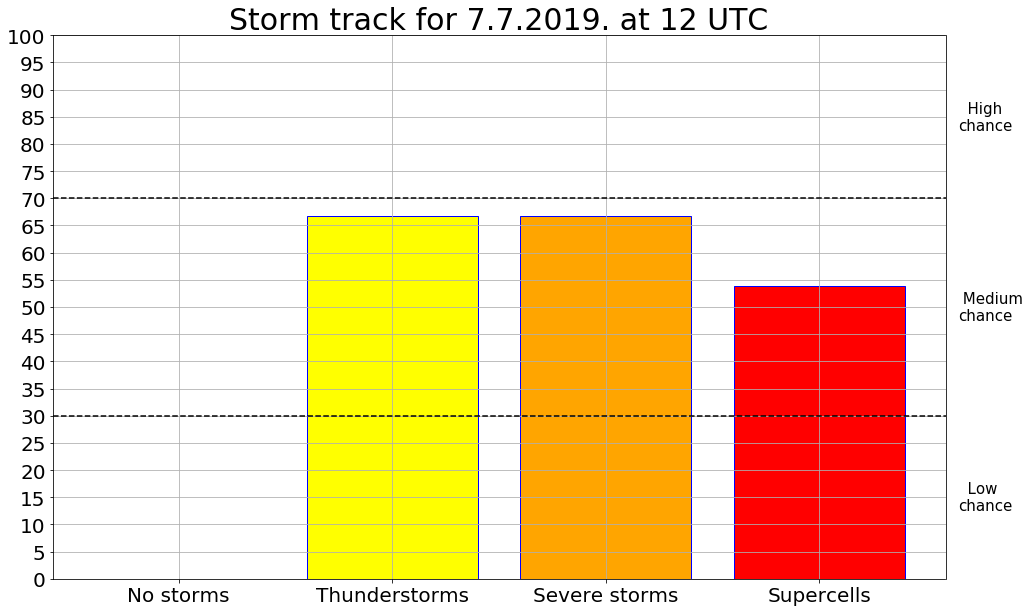

In [15]:
plt.bar(index, y, align='center', color=['green', 'yellow', 'orange', 'red'],  edgecolor='blue')
plt.xticks(index, x, fontsize = 20)
plt.yticks(np.arange(0, 105, 5), fontsize = 20)
plt.axhline(30, color="black", linestyle='dashed')
plt.text(3.65, 15, "  Low \nchance", va='center', ha="left",  fontsize = 15)
plt.axhline(70, color="black", linestyle='dashed')
plt.text(3.65, 50, " Medium \nchance", va='center', ha="left", fontsize = 15)
plt.text(3.65, 85, "  High \nchance", va='center', ha="left", fontsize = 15)
a = 'Storm track for {day}.{month}.{year}. at {hour} UTC'.format(day = date.day, month = date.month, year = date.year, hour = date.hour)
plt.title(a, fontsize = 30)
plt.grid()

## Conclusion

Results are pretty good, sounding area had very unstable afternoon that day. 

Skew T can be seen here:

http://weather.uwyo.edu/cgi-bin/sounding?region=europe&TYPE=GIF%3ASKEWT&YEAR=2019&MONTH=07&FROM=0712&TO=0712&STNM=LDDD